# Media GeoTag Mapper (MGTM):

A Python tool for retrieving, storing, and viewing image and video geotags

By Kenneth Burchfiel

Released under the MIT license

GitHub link: https://github.com/kburchfiel/media_geotag_mapper

This tutorial notebook shows how to use the functions in media_mapper_functions.py to retrieve geographic coordinates from your images and videos, then store them and view them as interactive maps.

For this tutorial, I'll be loading geotags from video clips and images that I've taken since June 2012. Most of the devices are Samsung Galaxy phones, but I'll also import images from my old Sony HDR-CX260V video camera, which predates my first smartphone. These same steps should work for pictures and videos taken with iPhones--at least for newer models. (I used media_geotag_mapper_iPhone_example_v2.ipynb for iPhone-content testing.)

**Note:** This script was heavily updated in January 2026 to use metadata-based creation times in place of modification times obtained through `os.stat()`, as I found the latter to often be inaccurate *or* lack time zone data.

First, I'll import a series of libraries:

In [53]:
import time
program_start_time = time.time() # Allows the program's runtime to be measured
import os
import pandas as pd
import numpy as np
import datetime
import plotly.express as px
import IPython.display
from IPython.display import display
import shutil

from media_geotag_functions_v6 import generate_media_list, \
    retrieve_pic_locations, retrieve_clip_locations, generate_loc_list, \
    map_media_locations, folder_list_to_map, flip_lon, create_map_screenshot, \
    calculate_distance_by_year, convert_png_to_smaller_jpg, \
    batch_create_map_screenshots, batch_convert_pngs_to_smaller_jpgs

Next, I'll create a list of the folder paths on my external hard drive that contain the images and video clips from which I'll want to extract geotag data. Since I import my media into device-specific folders, the folder names also show the various devices that I'll be using.

In [2]:
connection_type = 'local' # Can be 'sftp' or 'local'; this was added 
# for my own convenience but may not be necessary in your use case.

if connection_type == 'sftp':
    top_folder = '/home/kjb3/sshfs_ext_rclone_mount/'
else:
    top_folder = '/media/kjb3/KJB320TB1/'

folder_name = 'combined'

top_folder_list = [
# Pictures:
f'{top_folder}D1V1/Vids Clips Pics/1 Unsorted Pics/1 Sony HDRCX260V', 
f'{top_folder}D1V1/Vids Clips Pics/1 Unsorted Pics/2 Samsung Galaxy S4 Mini', 
f'{top_folder}D1V1/Vids Clips Pics/1 Unsorted Pics/28 Samsung Galaxy S5', 
f'{top_folder}D1V1/Vids Clips Pics/1 Unsorted Pics/30 Samsung Galaxy S7', 
f'{top_folder}D1V1/Vids Clips Pics/1 Unsorted Pics/34 Galaxy S21 Ultra', 
f'{top_folder}D1V1/Vids Clips Pics/1 Unsorted Pics/39 Samsung Galaxy S24 Ultra',
# Video clips:
f'{top_folder}D2V1/Vids Clips Pics/2 Unsorted Clips/2 Samsung Galaxy S4 Mini', 
f'{top_folder}D2V1/Vids Clips Pics/2 Unsorted Clips/28 Samsung Galaxy S5', 
f'{top_folder}D2V1/Vids Clips Pics/2 Unsorted Clips/30 Samsung Galaxy S7', 
f'{top_folder}D2V1/Vids Clips Pics/2 Unsorted Clips/34 Galaxy S21 Ultra',
f'{top_folder}D2V1/Vids Clips Pics/2 Unsorted Clips/39 Samsung Galaxy S24 Ultra']

top_folder_list

['/media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 Unsorted Pics/1 Sony HDRCX260V',
 '/media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 Unsorted Pics/2 Samsung Galaxy S4 Mini',
 '/media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 Unsorted Pics/28 Samsung Galaxy S5',
 '/media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 Unsorted Pics/30 Samsung Galaxy S7',
 '/media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 Unsorted Pics/34 Galaxy S21 Ultra',
 '/media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 Unsorted Pics/39 Samsung Galaxy S24 Ultra',
 '/media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 Unsorted Clips/2 Samsung Galaxy S4 Mini',
 '/media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 Unsorted Clips/28 Samsung Galaxy S5',
 '/media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 Unsorted Clips/30 Samsung Galaxy S7',
 '/media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 Unsorted Clips/34 Galaxy S21 Ultra',
 '/media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 Unsorted Clips/39 Samsung Galaxy S24 Ultra']

I found that running my code produced a number of cryptic RuntimeWarning messages. In order to prevent these from filling up my notebook's output, I added the following code--though you may want to comment it out on your end, particularly if it's not running as expected.

In [3]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

The following variable governs whether or not to create a new set of media and locations lists. This process can take a while and also requires access to the original media files, so it's best to run it once and then comment it out until you have new media to add.

In [4]:
generate_new_lists = False

The following cell calls generate_media_list in order to obtain a list of all files within these folders (and their corresponding subfolders). It also saves this file list as a .csv file. 

In [5]:
if generate_new_lists == True:
    df_media = generate_media_list(top_folder_list=top_folder_list,
    folder_name = folder_name, files_to_import = 0)

Here's a look at df_media. generate_loc_list iterates through this table in order to extract geotag data.

In [6]:
df_media = pd.read_csv(f'{folder_name}_media_list.csv')

df_media.head(5)

path          name  \
0  /media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 U...  DSC00001.JPG   
1  /media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 U...  DSC00002.JPG   
2  /media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 U...  DSC00003.JPG   
3  /media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 U...  DSC00004.JPG   
4  /media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 U...  DSC00005.JPG   

                    utc_ctime_estimate utc_modified_time_estimate  \
0  2024-12-13 01:39:37.216416597+00:00  2012-06-26 00:21:40+00:00   
1  2024-12-13 01:39:37.230818272+00:00  2012-06-26 00:21:44+00:00   
2  2024-12-13 01:39:37.250210524+00:00  2012-06-26 00:24:34+00:00   
3  2024-12-13 01:39:37.262487888+00:00  2012-06-26 00:24:38+00:00   
4  2024-12-13 01:39:37.275019646+00:00  2012-06-26 00:24:40+00:00   

            utc_accessed_time_estimate  megabytes extension type  
0  2024-12-14 22:55:49.361283779+00:00   2.812600       jpg  pic  
1  2024-12-14 22:55:49.429124594+00:00   3.246815       jpg  pic  
2  2024-12-14 22:55:49.506849289+00:00   2.818006       jpg  pic  
3  2024-12-14 22:55:49.574272633+00:00   2.730064       jpg  pic  
4  2024-12-14 22:55:49.645747185+00:00   2.862829       jpg  pic

The following cell removes two types of files from df_media.

Thousands of my images are simply copies of the first frame of videos; these images, which are stored within a '1st_Frames' folder, don't have location data and thus shouldn't be processed by generate_loc_list() below. Therefore, the cell excludes any item with '1st_Frames' in its path.

Next, the cell removes files that were created as video captures of .mp4 videos on a Samsung Galaxy phone. Although these files often contain location data, the time that a given video capture was created does **not** match the time that the original video file was created. Therefore, including them will cause maps to be drawn incorrectly. (Also, since the video files on which these video capture files are based already contain location data, the video capture's geotag data are redundant.)

You'll likely want to modify this cell to fit your own filtering needs.


In [7]:
print(len(df_media)) # These print statements will help ensure that the code
# is successfully removing unwanted files from df_media.
df_media = df_media[
df_media['path'].str.contains('1st_Frames') == False].copy()
print(len(df_media))
df_media = df_media[
(df_media['path'].str.lower().str.contains('videocapture') == False) & 
(df_media['path'].str.lower().str.contains('vcap') == False)].copy()
print(len(df_media))

93571
86377
63463


The following cell creates a subset of df_media that shows my video and image files from a trip to Israel in March 2022. It also saves this subset to a .csv file so that you can see what the structure of df_media looks like.

In [9]:
df_media_israel = df_media.query(
    "utc_modified_time_estimate > '2022-03-11 15:30' \
& utc_modified_time_estimate < '2022-03-18'").copy()
df_media_israel.to_csv('df_media_israel.csv', index = False)
df_media_israel


path                 name  \
42862  /media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 U...  20220311_111842.jpg   
42863  /media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 U...  20220311_111844.jpg   
42864  /media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 U...  20220311_111850.jpg   
42865  /media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 U...  20220311_111854.jpg   
42866  /media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 U...  20220311_223743.jpg   
...                                                  ...                  ...   
81851  /media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 U...  20220316_203425.mp4   
81852  /media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 U...  20220317_115710.mp4   
81853  /media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 U...  20220317_211408.mp4   
81875  /media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 U...  20220312_200006.mp4   
81876  /media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 U...  20220315_153714.mp4   

                        utc_ctime_estimate utc_modified_time_estimate  \
42862  2024-12-13 02:07:04.996206045+00:00  2022-03-11 17:18:43+00:00   
42863  2024-12-13 02:07:05.017471790+00:00  2022-03-11 17:18:45+00:00   
42864  2024-12-13 02:07:05.207998991+00:00  2022-03-11 17:18:54+00:00   
42865  2024-12-13 02:07:05.397697687+00:00  2022-03-11 17:18:59+00:00   
42866  2024-12-13 02:07:05.569765091+00:00  2022-03-12 03:37:46+00:00   
...                                    ...                        ...   
81851  2024-12-13 12:22:40.777034283+00:00  2022-03-17 00:34:31+00:00   
81852  2024-12-13 12:22:47.460987568+00:00  2022-03-17 15:57:17+00:00   
81853  2024-12-13 12:22:53.563982725+00:00  2022-03-17 19:14:12+00:00   
81875  2024-12-13 12:19:51.306645632+00:00  2022-03-13 01:00:10+00:00   
81876  2024-12-13 12:21:48.279953480+00:00  2022-03-15 19:37:20+00:00   

                utc_accessed_time_estimate  megabytes extension  type  
42862  2024-12-14 09:00:25.100737810+00:00   3.556796       jpg   pic  
42863  2024-12-14 09:00:25.018418550+00:00   3.657528       jpg   pic  
42864  2024-12-14 09:00:28.320000410+00:00  26.937528       jpg   pic  
42865  2024-12-14 09:00:28.473046303+00:00  26.904573       jpg   pic  
42866  2024-12-14 08:59:50.845668316+00:00  25.171938       jpg   pic  
...                                    ...        ...       ...   ...  
81851  2024-12-14 08:56:17.121443510+00:00  56.743989       mp4  clip  
81852  2024-12-14 08:56:08.225350380+00:00  62.341768       mp4  clip  
81853  2024-12-14 08:56:01.833485126+00:00  25.197927       mp4  clip  
81875  2024-12-14 08:59:21.778781891+00:00  35.681784       mp4  clip  
81876  2024-12-14 08:57:16.358007193+00:00  51.826984       mp4  clip  

[770 rows x 8 columns]

The next cell calls generate_loc_list to search for geographic coordinate data stored within the EXIF data/metadata of each image and video file, then stores those coordinates within another .csv file. This cell can take a while to run depending on the number of media files through which it needs to search.

In [8]:
if generate_new_lists == True:
    df_all_locations = generate_loc_list(
        df_media = df_media, 
        #df_media = df_media.sample(frac=0.01), # Useful for debugging
    folder_name = folder_name)
    # Running this code with 39,900 pictures and 23,614 videos
    # took 39m53s.

I'll next create df_all_locations, a DataFrame containing all location data provided for the files in df_media. I'll limit the sample output of this notebook to geotags taken within Colorado.

In [10]:
co_min_lat = 37
co_max_lat = 41
co_min_lon = -1*((109)+(2/60)+(48/3600))
co_max_lon = -1*((102)+(2/60)+(48/3600))
# These are the boundaries of Colorado set by Congress in 1861. The 
# modern boundaries probably differ slightly. See
# https://en.wikipedia.org/wiki/Colorado#Geography

When mapping the geotags shown in df_all_locations, I realized that some pictures had a positive (East) longitude when they should have had a negative (West) longitude. This was apparently due to an error in the original geotag data. Therefore, I created a function called flip_lon that reversed the longitude coordinates of geotags that appeared in a certain frame. Like the other functions, I stored it within media_mapper_functions.py.

In [11]:
if generate_new_lists == True:
    df_all_locations = flip_lon(df_all_locations, lat_south_bound = 25,
    lat_north_bound = 45, lon_west_bound = 70, lon_east_bound = 95)
    df_all_locations.to_csv(f'{folder_name}_media_locations.csv', 
index = False)
# Reading either the file we just saved or a pre-existing file into
# memory:
df_all_locations = pd.read_csv(f'{folder_name}_media_locations.csv')

# Converting date/time columns from the .csv file back into UTC DateTimes:
for col in ['utc_ctime_estimate',
            'utc_modified_time_estimate',
            'utc_accessed_time_estimate',
            'utc_metadata_creation_time']:
    df_all_locations[col] = pd.to_datetime(df_all_locations[col], utc=True,
                                          format='mixed')


In [12]:
df_all_locations.query("lat >= @co_min_lat & lat <= @co_max_lat & \
lon >= @co_min_lon & lon <= @co_max_lon")

path                 name  \
1026   /media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 U...         DSC01036.JPG   
1027   /media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 U...         DSC01037.JPG   
1028   /media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 U...         DSC01038.JPG   
1029   /media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 U...         DSC01039.JPG   
1030   /media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 U...         DSC01040.JPG   
...                                                  ...                  ...   
50394  /media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 U...  20220305_200935.mp4   
50395  /media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 U...  20220305_201836.mp4   
50396  /media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 U...  20220305_202156.mp4   
50397  /media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 U...  20220306_062843.mp4   
50398  /media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 U...  20220306_070536.mp4   

                       utc_ctime_estimate utc_modified_time_estimate  \
1026  2024-12-13 01:39:49.960318089+00:00  2012-12-17 02:29:34+00:00   
1027  2024-12-13 01:39:49.969498396+00:00  2012-12-17 02:29:42+00:00   
1028  2024-12-13 01:39:49.976199389+00:00  2012-12-17 02:30:02+00:00   
1029  2024-12-13 01:39:49.992553473+00:00  2012-12-17 02:34:30+00:00   
1030  2024-12-13 01:39:50.000523806+00:00  2012-12-17 02:34:42+00:00   
...                                   ...                        ...   
50394 2024-12-13 12:17:26.825420618+00:00  2022-03-06 03:09:42+00:00   
50395 2024-12-13 12:17:26.925952435+00:00  2022-03-06 03:18:40+00:00   
50396 2024-12-13 12:17:27.086977482+00:00  2022-03-06 03:22:02+00:00   
50397 2024-12-13 12:17:27.544514179+00:00  2022-03-06 13:28:51+00:00   
50398 2024-12-13 12:17:28.144729137+00:00  2022-03-06 14:05:40+00:00   

               utc_accessed_time_estimate  megabytes extension  type  \
1026  2024-12-14 22:56:10.865446806+00:00   1.815763       jpg   pic   
1027  2024-12-14 22:56:10.880414724+00:00   2.493354       jpg   pic   
1028  2024-12-14 22:56:10.895370960+00:00   1.746941       jpg   pic   
1029  2024-12-14 22:56:10.913144827+00:00   2.071690       jpg   pic   
1030  2024-12-14 22:56:10.926391363+00:00   2.009213       jpg   pic   
...                                   ...        ...       ...   ...   
50394 2024-12-14 09:05:15.861714363+00:00  58.041035       mp4  clip   
50395 2024-12-14 09:05:15.793171406+00:00  14.585707       mp4  clip   
50396 2024-12-14 09:05:16.184008598+00:00  23.778639       mp4  clip   
50397 2024-12-14 09:05:15.253147840+00:00  67.196104       mp4  clip   
50398 2024-12-14 09:05:14.726449013+00:00  36.135166       mp4  clip   

             raw_location        lat         lon utc_metadata_creation_time  
1026                    0  40.541800 -102.062050  2012-12-17 04:29:36+00:00  
1027                    0  40.538069 -102.082196  2012-12-17 04:29:44+00:00  
1028                    0  40.528293 -102.135088  2012-12-17 04:30:05+00:00  
1029                    0  40.520737 -102.175474  2012-12-17 04:30:21+00:00  
1030                    0  40.520737 -102.175474  2012-12-17 04:30:21+00:00  
...                   ...        ...         ...                        ...  
50394  +39.1901-106.8190/  39.190100 -106.819000  2022-03-06 03:09:42+00:00  
50395  +39.1875-106.8227/  39.187500 -106.822700  2022-03-06 03:18:40+00:00  
50396  +39.1860-106.8231/  39.186000 -106.823100  2022-03-06 03:22:02+00:00  
50397  +39.1857-106.8236/  39.185700 -106.823600  2022-03-06 13:28:51+00:00  
50398  +39.1867-106.8231/  39.186700 -106.823100  2022-03-06 14:05:40+00:00  

[1498 rows x 12 columns]

In [13]:
df_all_locations.query("lon > 70 & lon < 95 & lat > 25 & lat < 45") 
# Confirms that I flipped all longitude coordinates within this frame
# back to their correct value

Empty DataFrame
Columns: [path, name, utc_ctime_estimate, utc_modified_time_estimate, utc_accessed_time_estimate, megabytes, extension, type, raw_location, lat, lon, utc_metadata_creation_time]
Index: []

The following four variables will be used within my mapping and screenshot generation code.

In [14]:
path_to_map_folder = os.getcwd()+'/maps'
screenshot_save_path = 'map_screenshots'
default_window_width = 3000
default_intl_window_width = 4200

Next, I'll create a map of all the geotags present within df_all_locations.

In [16]:
combined_map = map_media_locations(df_all_locations, folder_path = 'maps', 
file_name = 'combined', zoom_start = 6)

Added 53438 markers to the map.


Next, I'll create a screenshot of this map, along with a smaller copy of this screenshot. The latter is shown below.

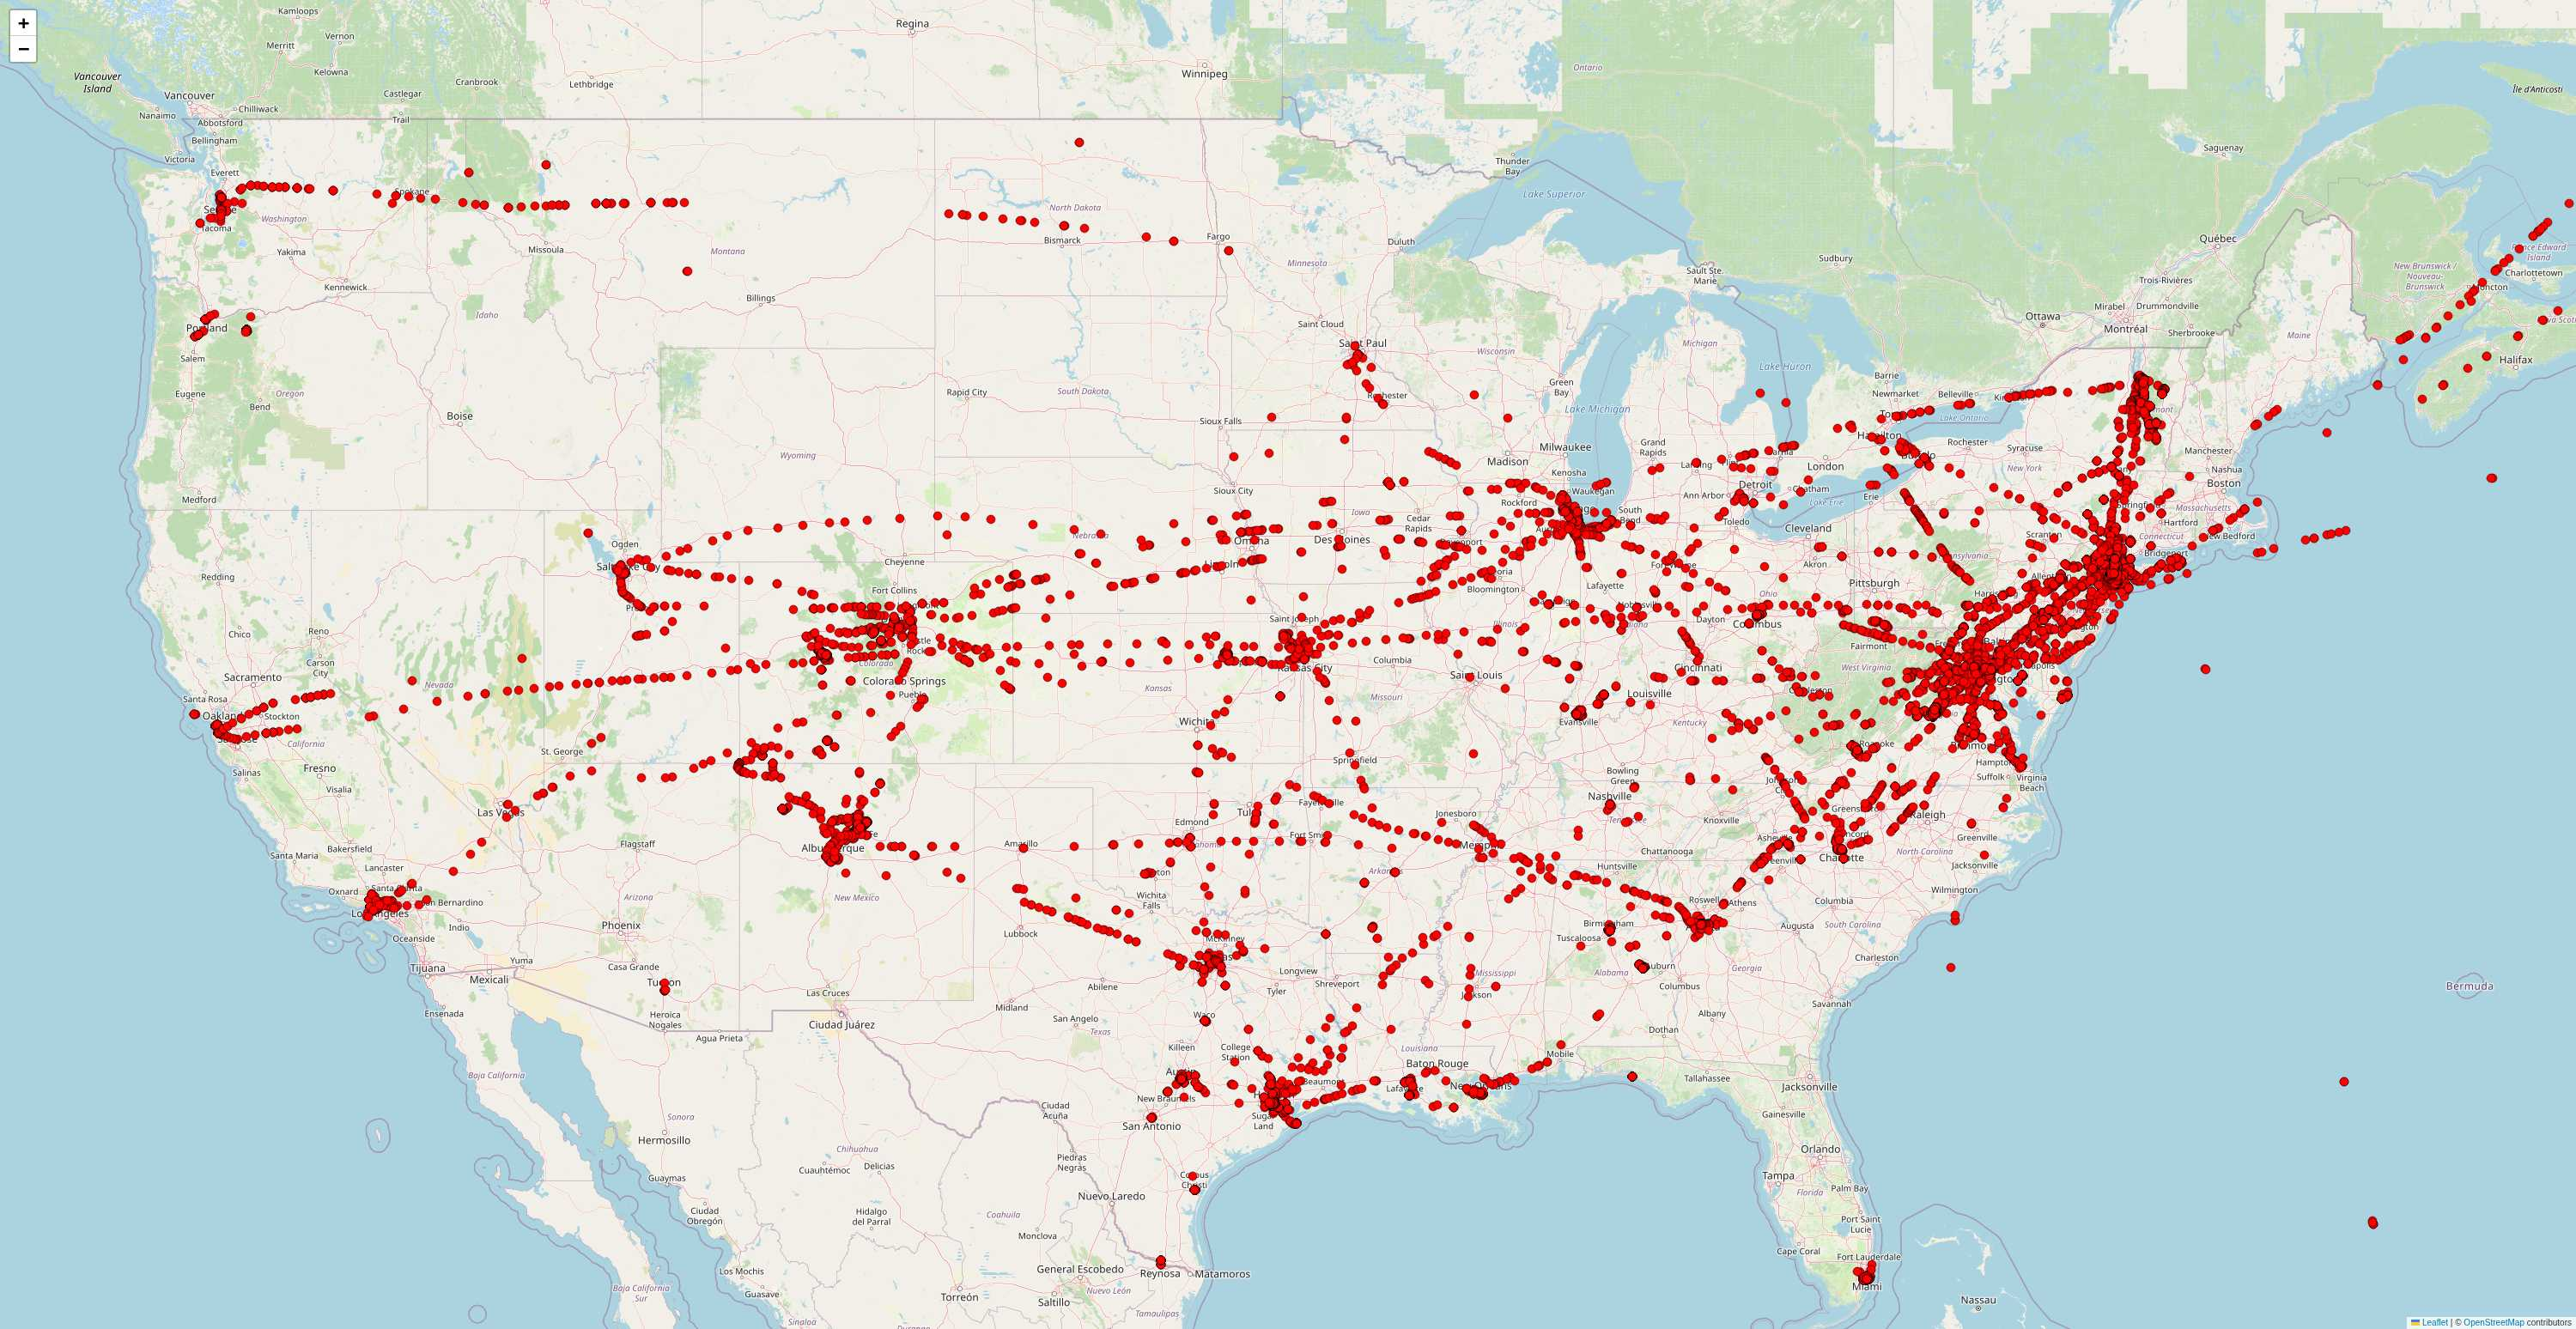

In [17]:
create_map_screenshot(path_to_map_folder = 
path_to_map_folder, map_name= 'combined_locations.html', 
screenshot_save_path = screenshot_save_path, 
window_width = default_window_width)

convert_png_to_smaller_jpg(png_folder = 'map_screenshots', 
png_image_name = 'combined_locations.png', 
jpg_folder = 'smaller_screenshots', 
reduction_factor = 1, quality_factor = 50)

IPython.display.display(IPython.display.Image(
    filename='smaller_screenshots/'+'combined_locations.jpg'))
# This code is based on DrMcCleod's response at:
# https://stackoverflow.com/a/35061341/13097194

I've traveled around a lot since June 2012 (when I first got my Sony HDR-CX260V camcorder). You can tell from the map that I've spent lots of time in Houston, the DC area, New York, and Chicago, to name a few cities. However, as you'll see later in this notebook, adding paths in between these locations can make it easier to interpret the map.

df_all_locations works fine as a data source for mapping geotags as individual points. However, I wanted to visualize not only points, but also the paths between geotags, which would give me a better sense of where I traveled each year. In order to accurately visualize these paths, I would need to have a DataFrame in which the rows are sorted in chronological order.

Therefore, I created a copy of df_all_locations (df_locations) that excludes entries with a latitude and longitude of 0, since these represented missing geotag data. I might have to update this code if I ever visit [Null Island](https://en.wikipedia.org/wiki/Null_Island)! ;) 

In [18]:
# Here with editing: Find out why there are still nan values within utc_file_time_for_sorting

In [19]:
print(len(df_all_locations))
df_locations = df_all_locations.query("lat != 0 & lon != 0").copy()
# Removing all values that do not have valid UTC metadata creation times:
# (Previously, I had also allowed utc_modified_time_estimate values to 
# be substituted for these values; however, since I later realized that
# these modification times often do *not* reflect actual UTC times,
# and because I was able to get valid utc_metadata_creation_time
# values for the vast majority of my files, I decided to simply exclude
# rows that didn't have utc_metadata_creation_time values.)
print(len(df_locations))
df_locations.query("utc_metadata_creation_time.notna()", inplace = True)
print(len(df_locations))

df_locations.reset_index(drop=True,inplace=True)
# Sorting these values by their metadata-based 
# creation time: (This will be crucial
# in order for our route maps to display accurate connections between
# points.)
df_locations.sort_values('utc_metadata_creation_time', inplace = True)
# df_locations

62970
53438
53246


Debugging EXIF data retrieval:

The following cell creates a subset of df_locations that shows all the geotags from my Israel trip. It saves this subset to a .csv file so that you can see what the structure of df_locations looks like.

In [20]:
df_locations_israel = df_locations.query(
    "utc_metadata_creation_time > '2022-03-11 15:30+0000' \
& utc_metadata_creation_time < '2022-03-18 00:00+0000'").copy()

df_locations_israel.to_csv('df_locations_israel.csv',
index = False)

df_locations_israel

path                 name  \
41726  /media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 U...  20220311_173221.mp4   
41727  /media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 U...  20220311_173333.mp4   
41728  /media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 U...  20220311_195916.mp4   
41729  /media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 U...  20220311_200214.mp4   
41730  /media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 U...  20220311_201139.mp4   
...                                                  ...                  ...   
23742  /media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 U...  20220317_211424.jpg   
23743  /media/kjb3/KJB320TB1/D1V1/Vids Clips Pics/1 U...  20220317_212925.jpg   
42092  /media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 U...  20220317_215712.mp4   
42093  /media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 U...  20220317_215756.mp4   
42094  /media/kjb3/KJB320TB1/D2V1/Vids Clips Pics/2 U...  20220317_215805.mp4   

                       utc_ctime_estimate utc_modified_time_estimate  \
41726 2024-12-13 12:19:18.314497232+00:00  2022-03-11 22:32:28+00:00   
41727 2024-12-13 12:19:18.882589102+00:00  2022-03-11 22:33:42+00:00   
41728 2024-12-13 12:19:19.353344202+00:00  2022-03-12 00:59:25+00:00   
41729 2024-12-13 12:19:19.628618479+00:00  2022-03-12 01:02:19+00:00   
41730 2024-12-13 12:19:20.409502745+00:00  2022-03-12 01:11:51+00:00   
...                                   ...                        ...   
23742 2024-12-13 02:07:08.222251415+00:00  2022-03-17 19:14:32+00:00   
23743 2024-12-13 02:07:08.236966133+00:00  2022-03-17 19:29:26+00:00   
42092 2024-12-13 12:22:53.628626823+00:00  2022-03-17 19:57:14+00:00   
42093 2024-12-13 12:22:53.934661627+00:00  2022-03-17 19:58:01+00:00   
42094 2024-12-13 12:22:54.369844675+00:00  2022-03-17 19:58:12+00:00   

               utc_accessed_time_estimate   megabytes extension  type  \
41726 2024-12-14 08:59:55.003489494+00:00   53.524944       mp4  clip   
41727 2024-12-14 08:59:54.562344790+00:00   84.044346       mp4  clip   
41728 2024-12-14 08:59:54.114459038+00:00   69.771367       mp4  clip   
41729 2024-12-14 08:59:53.927984953+00:00   39.541241       mp4  clip   
41730 2024-12-14 08:59:53.362737179+00:00  115.524176       mp4  clip   
...                                   ...         ...       ...   ...   
23742 2024-12-14 08:56:01.749463797+00:00    1.391799       jpg   pic   
23743 2024-12-14 08:56:01.695115089+00:00    2.669465       jpg   pic   
42092 2024-12-14 08:56:00.877164841+00:00    6.647322       mp4  clip   
42093 2024-12-14 08:56:01.429884672+00:00   46.851089       mp4  clip   
42094 2024-12-14 08:56:01.135197639+00:00   66.533674       mp4  clip   

             raw_location        lat        lon utc_metadata_creation_time  
41726  +32.0796+034.7678/  32.079600  34.767800  2022-03-11 15:32:28+00:00  
41727  +32.0794+034.7678/  32.079400  34.767800  2022-03-11 15:33:42+00:00  
41728  +32.0794+034.7674/  32.079400  34.767400  2022-03-11 17:59:25+00:00  
41729  +32.0794+034.7674/  32.079400  34.767400  2022-03-11 18:02:19+00:00  
41730  +32.0794+034.7674/  32.079400  34.767400  2022-03-11 18:11:51+00:00  
...                   ...        ...        ...                        ...  
23742                   0  32.059922  34.771513  2022-03-17 19:14:26+00:00  
23743                   0  32.060212  34.771503  2022-03-17 19:29:25+00:00  
42092  +32.0813+034.7680/  32.081300  34.768000  2022-03-17 19:57:14+00:00  
42093  +32.0813+034.7680/  32.081300  34.768000  2022-03-17 19:58:01+00:00  
42094  +32.0813+034.7680/  32.081300  34.768000  2022-03-17 19:58:12+00:00  

[481 rows x 12 columns]

Now that I have my sorted DataFrame, I can begin creating maps that show path information.

I'll first show two small-scale examples with fewer than 500 points. First, I'll show a map of a trip to Israel that I went on in March 2022 (using the df_locations_israel DataFrame):

In [21]:
df_locations_israel = pd.read_csv('df_locations_israel.csv')
israel_trip_map = map_media_locations(df_locations_israel, 
    folder_path = 'maps', file_name = '2022_03_Israel_trip', 
    starting_location = [32, 35], zoom_start = 9, add_paths = True)
israel_trip_map

Added 481 markers to the map.


Note that hovering over a given point brings up a tooltip with both the file's modified date and the geotags (geographic coordiates) of that file. If you *click* on a point, you'll be able to see the original file name.

The map is zoomed in in order to compensate for how my screenshot generation code works, so feel free to zoom out and pan the map around. For instance, if you zoom into Jerusalem, you can see the path of my journeys around the Old City.

Next, I'll create a similar map showing a trip to Miami that I went on the following month. (The MBA allows for lots of travel, especially during your final semester!) I'll change some of the aesthetic arguments passed to map_media_locations for demonstration purposes.

In [22]:
miami_trip_map = map_media_locations(df_locations.query(
    "utc_metadata_creation_time > '2022-04-08 19:00+0000' & utc_metadata_creation_time < '2022-04-11 15:30+0000'"), 
    folder_path = 'maps', file_name = '2022_04_Miami_trip', 
    starting_location = [25.77, -80.2], 
zoom_start = 14, add_paths = True,
circle_marker_color='#00ff00', radius = 8, tiles = 'OpenStreetMap',
path_color = 'purple', path_weight = 2)
miami_trip_map

Added 209 markers to the map.


You'll get a better view of the map if you zoom out a little bit. (As with the Israel map, it's zoomed in to compensate for how my screenshot generation code works.)

Next, I'll create maps showing all 23,000+ geotags in df_locations, along with paths connecting these points. One map will be zoomed in to focus on the US, whereas the other map will be zoomed out to show a global view.

In [23]:
map_media_locations(df_locations, folder_path = 'maps', 
file_name = 'combined_routes', add_paths = True, zoom_start = 6)

map_media_locations(df_locations, folder_path = 'maps', 
file_name = 'combined_routes_intl', add_paths = True, zoom_start = 4)
print("Done")

Added 53246 markers to the map.
Added 53246 markers to the map.
Done


Here's a look at the domestic version of the map:

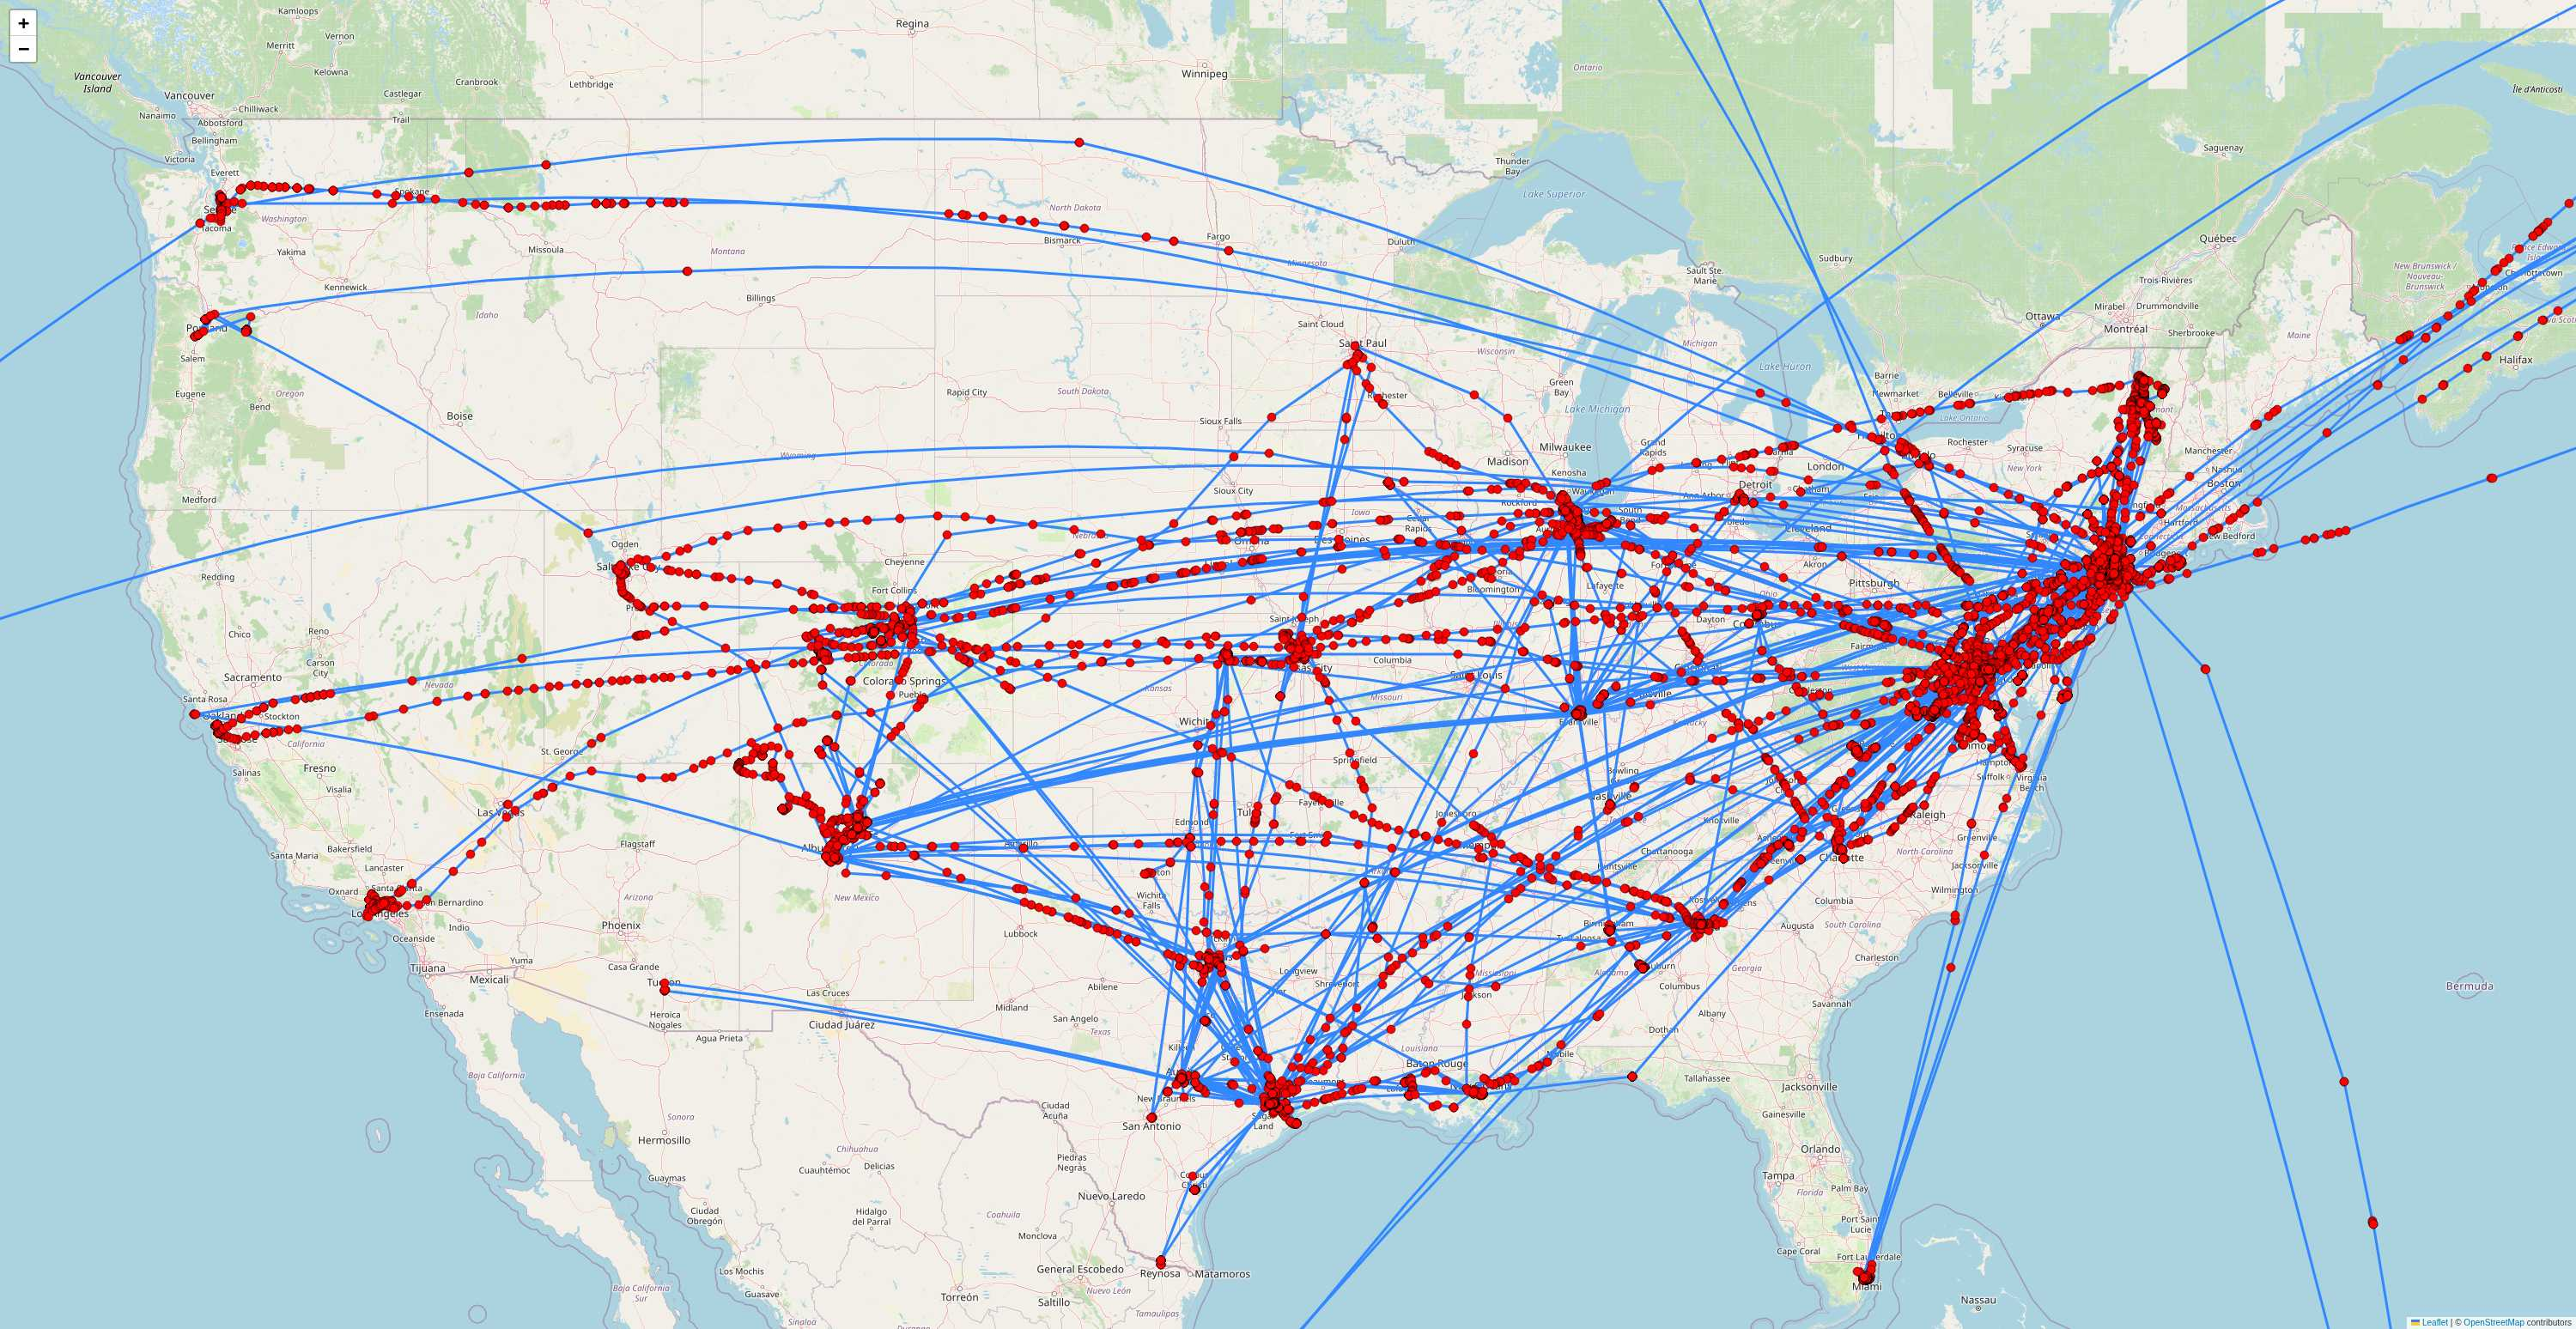

In [24]:
create_map_screenshot(path_to_map_folder = path_to_map_folder,
map_name= 'combined_routes_locations.html', 
screenshot_save_path = screenshot_save_path, window_width=default_window_width)

convert_png_to_smaller_jpg(png_folder = 'map_screenshots', 
png_image_name = 'combined_routes_locations.png', 
jpg_folder = 'smaller_screenshots', reduction_factor = 1, quality_factor = 50)

IPython.display.display(IPython.display.Image(
    filename='smaller_screenshots/'+'combined_routes_locations.jpg'))

This map is admittedly hard to read, given that it plots tens of thousands of points and their corresponding paths, but it does show both places where I've been and what my journey in between those places has looked like. For instance, it's clear that I traveled from New York to Miami and from Texas to Arizona. Later in this notebook, I'll create individual maps for each year, which will provide a clearer picture of where I've traveled (and lived) over time.

Here's a look at the global version of the previous map:

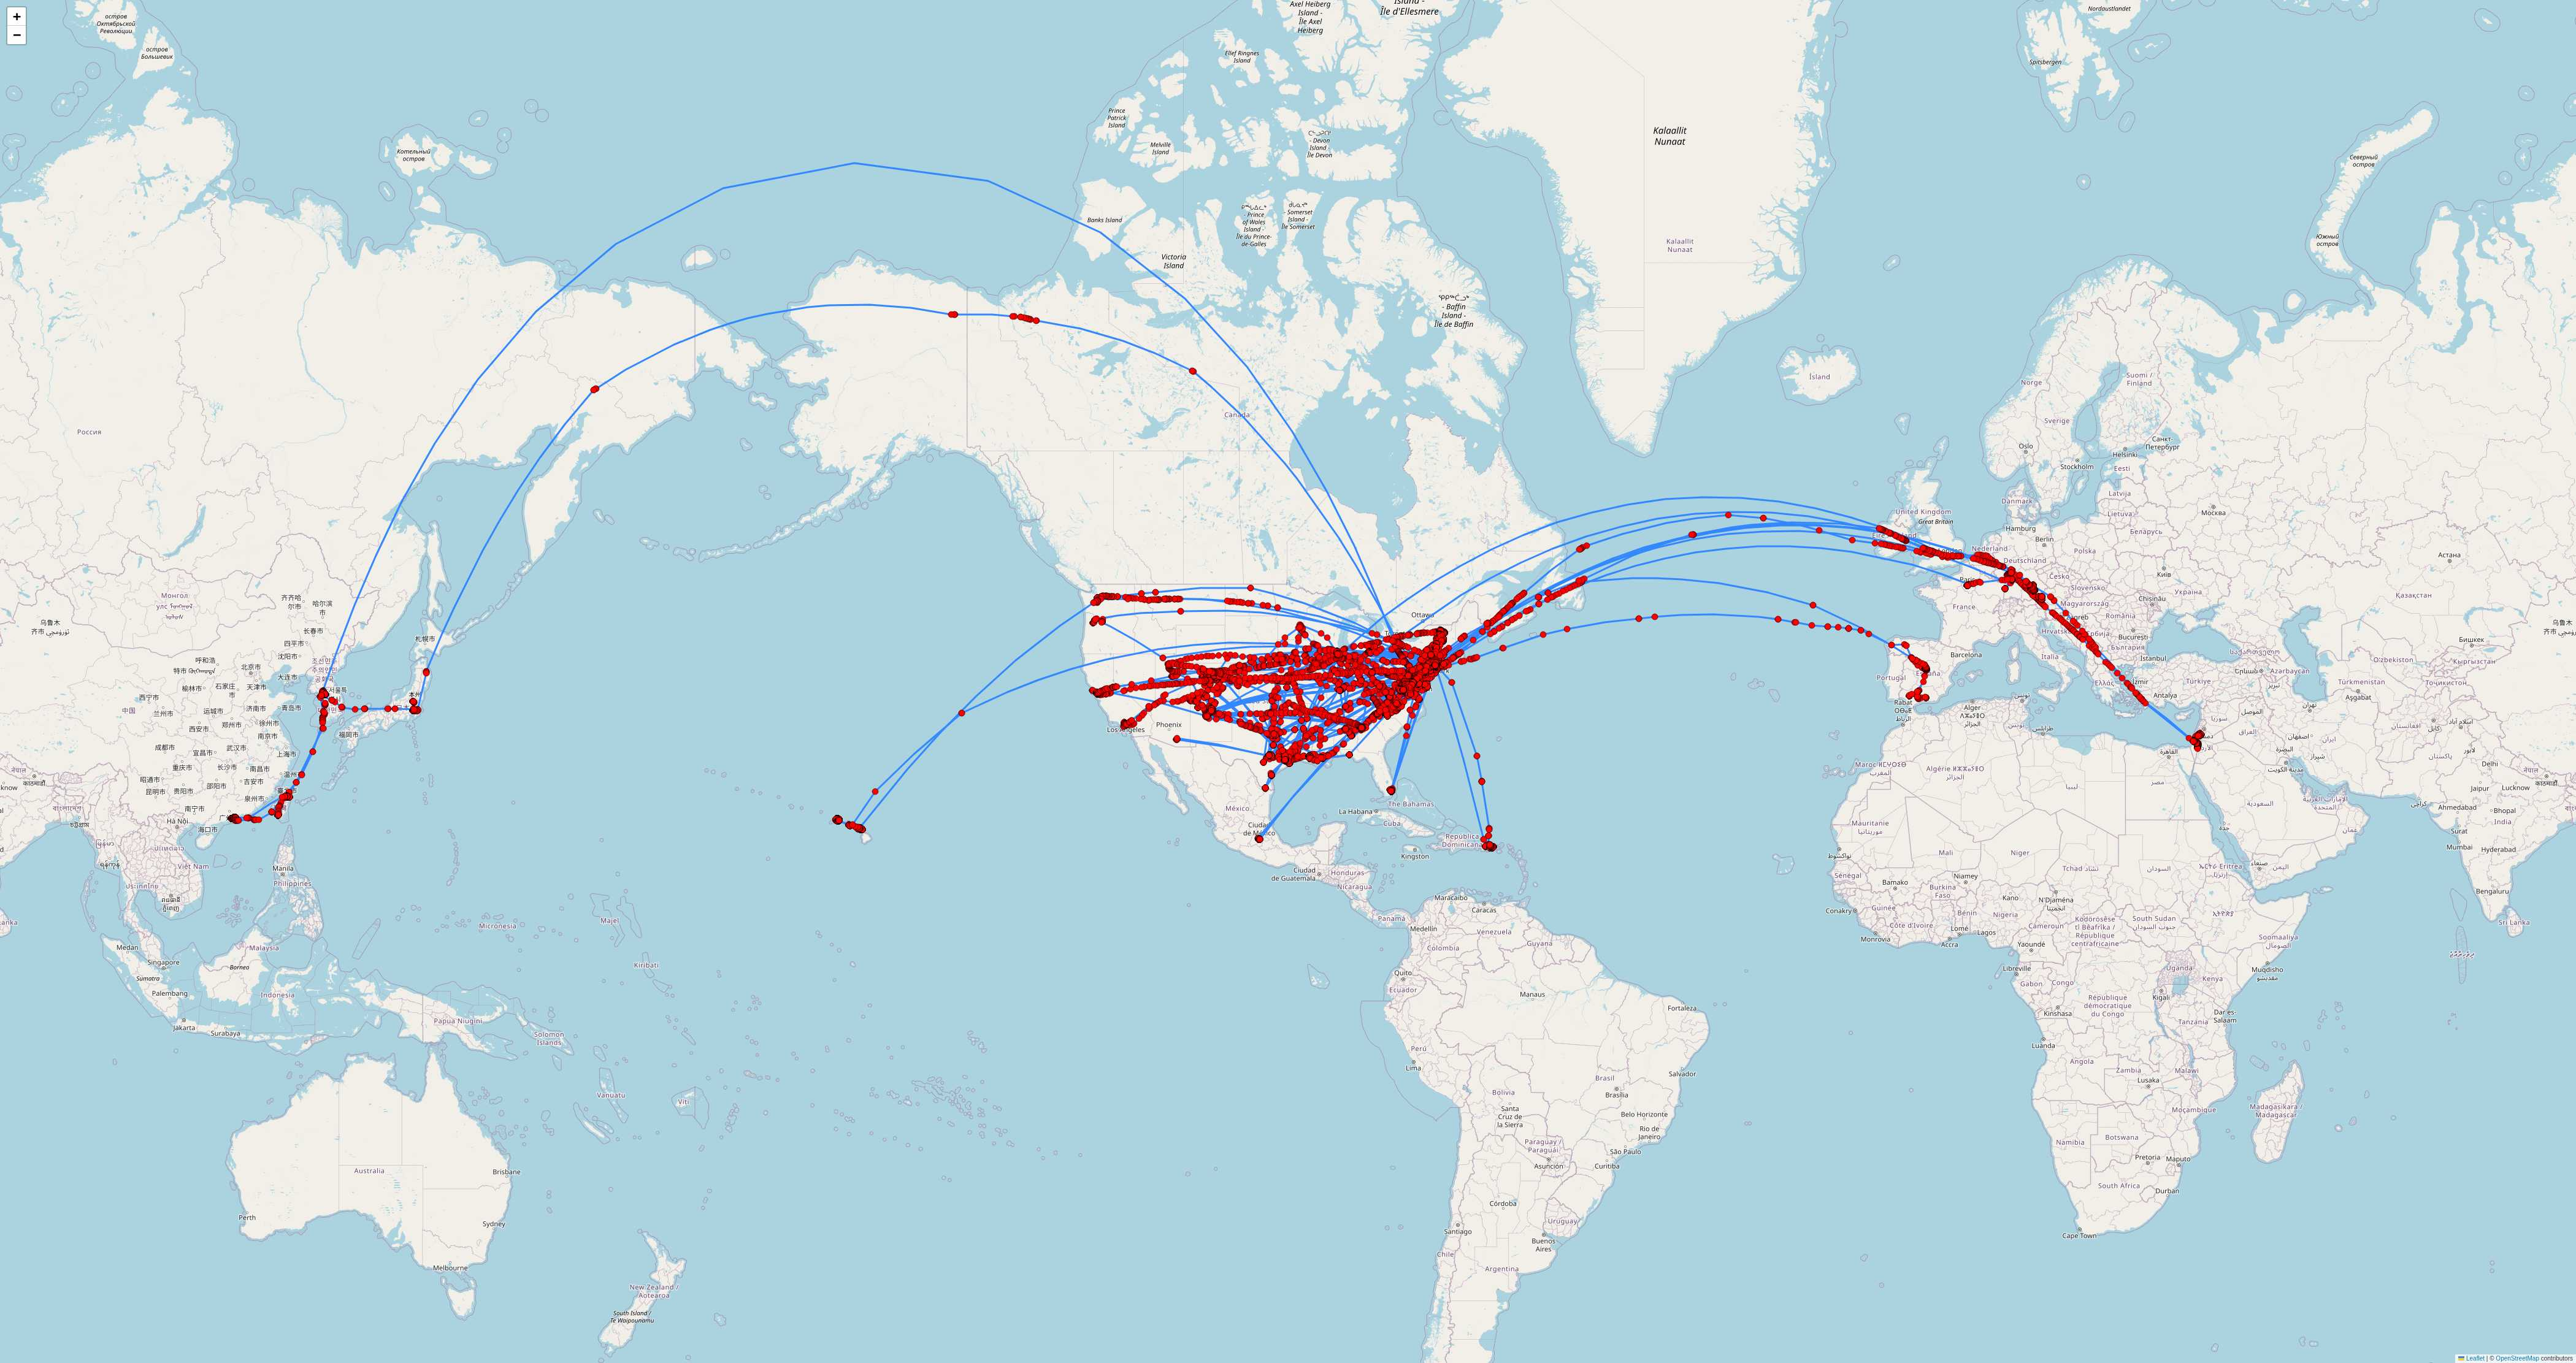

In [25]:
create_map_screenshot(path_to_map_folder = path_to_map_folder,
map_name= 'combined_routes_intl_locations.html', 
screenshot_save_path = screenshot_save_path, window_width=4200)

convert_png_to_smaller_jpg(png_folder = 'map_screenshots', 
png_image_name = 'combined_routes_intl_locations.png', 
jpg_folder = 'smaller_screenshots', reduction_factor = 1, quality_factor = 50)

IPython.display.display(IPython.display.Image(
    filename='smaller_screenshots/'+'combined_routes_intl_locations.jpg'))

To make it easier to see how my travel (and places of residence) changed over time, I'll next create maps showing the geotags and paths for each year.

In [26]:
international_travel_years = [2013, 2018, 2022, 2023, 2024, 2025] 
# These are the years in df_locations with international geotags.

In [27]:
map_dict = {}
for i in range(2012, datetime.date.today().year+1):
    # Determining the start times (in UTC) of the current year 
    # and the following year: (We need UTC-based times in order to 
    # allow for comparisons with the UTC-based utc_metadata_creation_time 
    # values.)
    start_time = f"{str(i)}-01-01 00:00+00:00"
    next_year_start_time = f"{str(i+1)}-01-01 00:00+00:00"
    df_locs_for_year = df_locations.query(
        "utc_metadata_creation_time >= @start_time \
& utc_metadata_creation_time < @next_year_start_time")
    if len(df_locs_for_year) > 0:
        print(f"Creating map for {i}:")
        map_dict[i] = map_media_locations(df_locs_for_year,
        folder_path = 'maps', file_name = f'{i}_combined', 
            add_paths = True, zoom_start = 6)
        if i in international_travel_years:
            map_media_locations(df_locations.query(
                "utc_metadata_creation_time >= @start_time \
    & utc_metadata_creation_time < @next_year_start_time"),
                folder_path = 'maps', file_name = f'{i}_combined_intl',
                add_paths = True, zoom_start = 4)

Creating map for 2012:
Added 1448 markers to the map.
Creating map for 2013:
Added 4199 markers to the map.
Added 4199 markers to the map.
Creating map for 2014:
Added 1728 markers to the map.
Creating map for 2015:
Added 1286 markers to the map.
Creating map for 2016:
Added 2871 markers to the map.
Creating map for 2017:
Added 239 markers to the map.
Creating map for 2018:
Added 327 markers to the map.
Added 327 markers to the map.
Creating map for 2019:
Added 289 markers to the map.
Creating map for 2020:
Added 2164 markers to the map.
Creating map for 2021:
Added 5958 markers to the map.
Creating map for 2022:
Added 10399 markers to the map.
Added 10399 markers to the map.
Creating map for 2023:
Added 6494 markers to the map.
Added 6494 markers to the map.
Creating map for 2024:
Added 8764 markers to the map.
Added 8764 markers to the map.
Creating map for 2025:
Added 7074 markers to the map.
Added 7074 markers to the map.
Creating map for 2026:
Added 6 markers to the map.


I now have .html versions of these maps, but to make them easier to share, I'll now create .png screenshots of these maps, then convert those .png screenshots to smaller .jpg files. I'll display the output of these screenshots later in this notebook.

In [28]:
batch_create_map_screenshots(path_to_map_folder = 
path_to_map_folder, screenshot_save_path = 
screenshot_save_path, window_width=default_window_width)

In [29]:
batch_convert_pngs_to_smaller_jpgs(png_folder = 'map_screenshots', 
    jpg_folder = 'smaller_screenshots', reduction_factor = 1, 
    quality_factor = 50) 

Here are the smaller .jpg versions of my map screenshots, some of which I'll display below:

In [30]:
for root, dirs, files in os.walk('smaller_screenshots'):
    smaller_screenshot_list = files

smaller_screenshot_list

['2022_combined_intl_locations.jpg',
 '2021_combined_locations.jpg',
 '2016_combined_locations.jpg',
 '2025_combined_intl_locations.jpg',
 '2018_combined_intl_locations.jpg',
 '2015_combined_locations.jpg',
 '2024_combined_locations.jpg',
 '2019_combined_locations.jpg',
 '2013_combined_intl_locations.jpg',
 '2022_combined_locations.jpg',
 '2024_combined_intl_locations.jpg',
 '2025_combined_locations.jpg',
 '2017_combined_locations.jpg',
 '2023_combined_locations.jpg',
 '2026_combined_locations.jpg',
 '2022_04_Miami_trip_locations.jpg',
 'combined_locations.jpg',
 '2014_combined_locations.jpg',
 'combined_routes_locations.jpg',
 'combined_routes_intl_locations.jpg',
 '2022_03_Israel_trip_locations.jpg',
 '2012_combined_locations.jpg',
 '2013_combined_locations.jpg',
 '2020_combined_locations.jpg',
 '2023_combined_intl_locations.jpg',
 '2018_combined_locations.jpg']

In 2012, I spent lots of time in Vermont and Virginia:

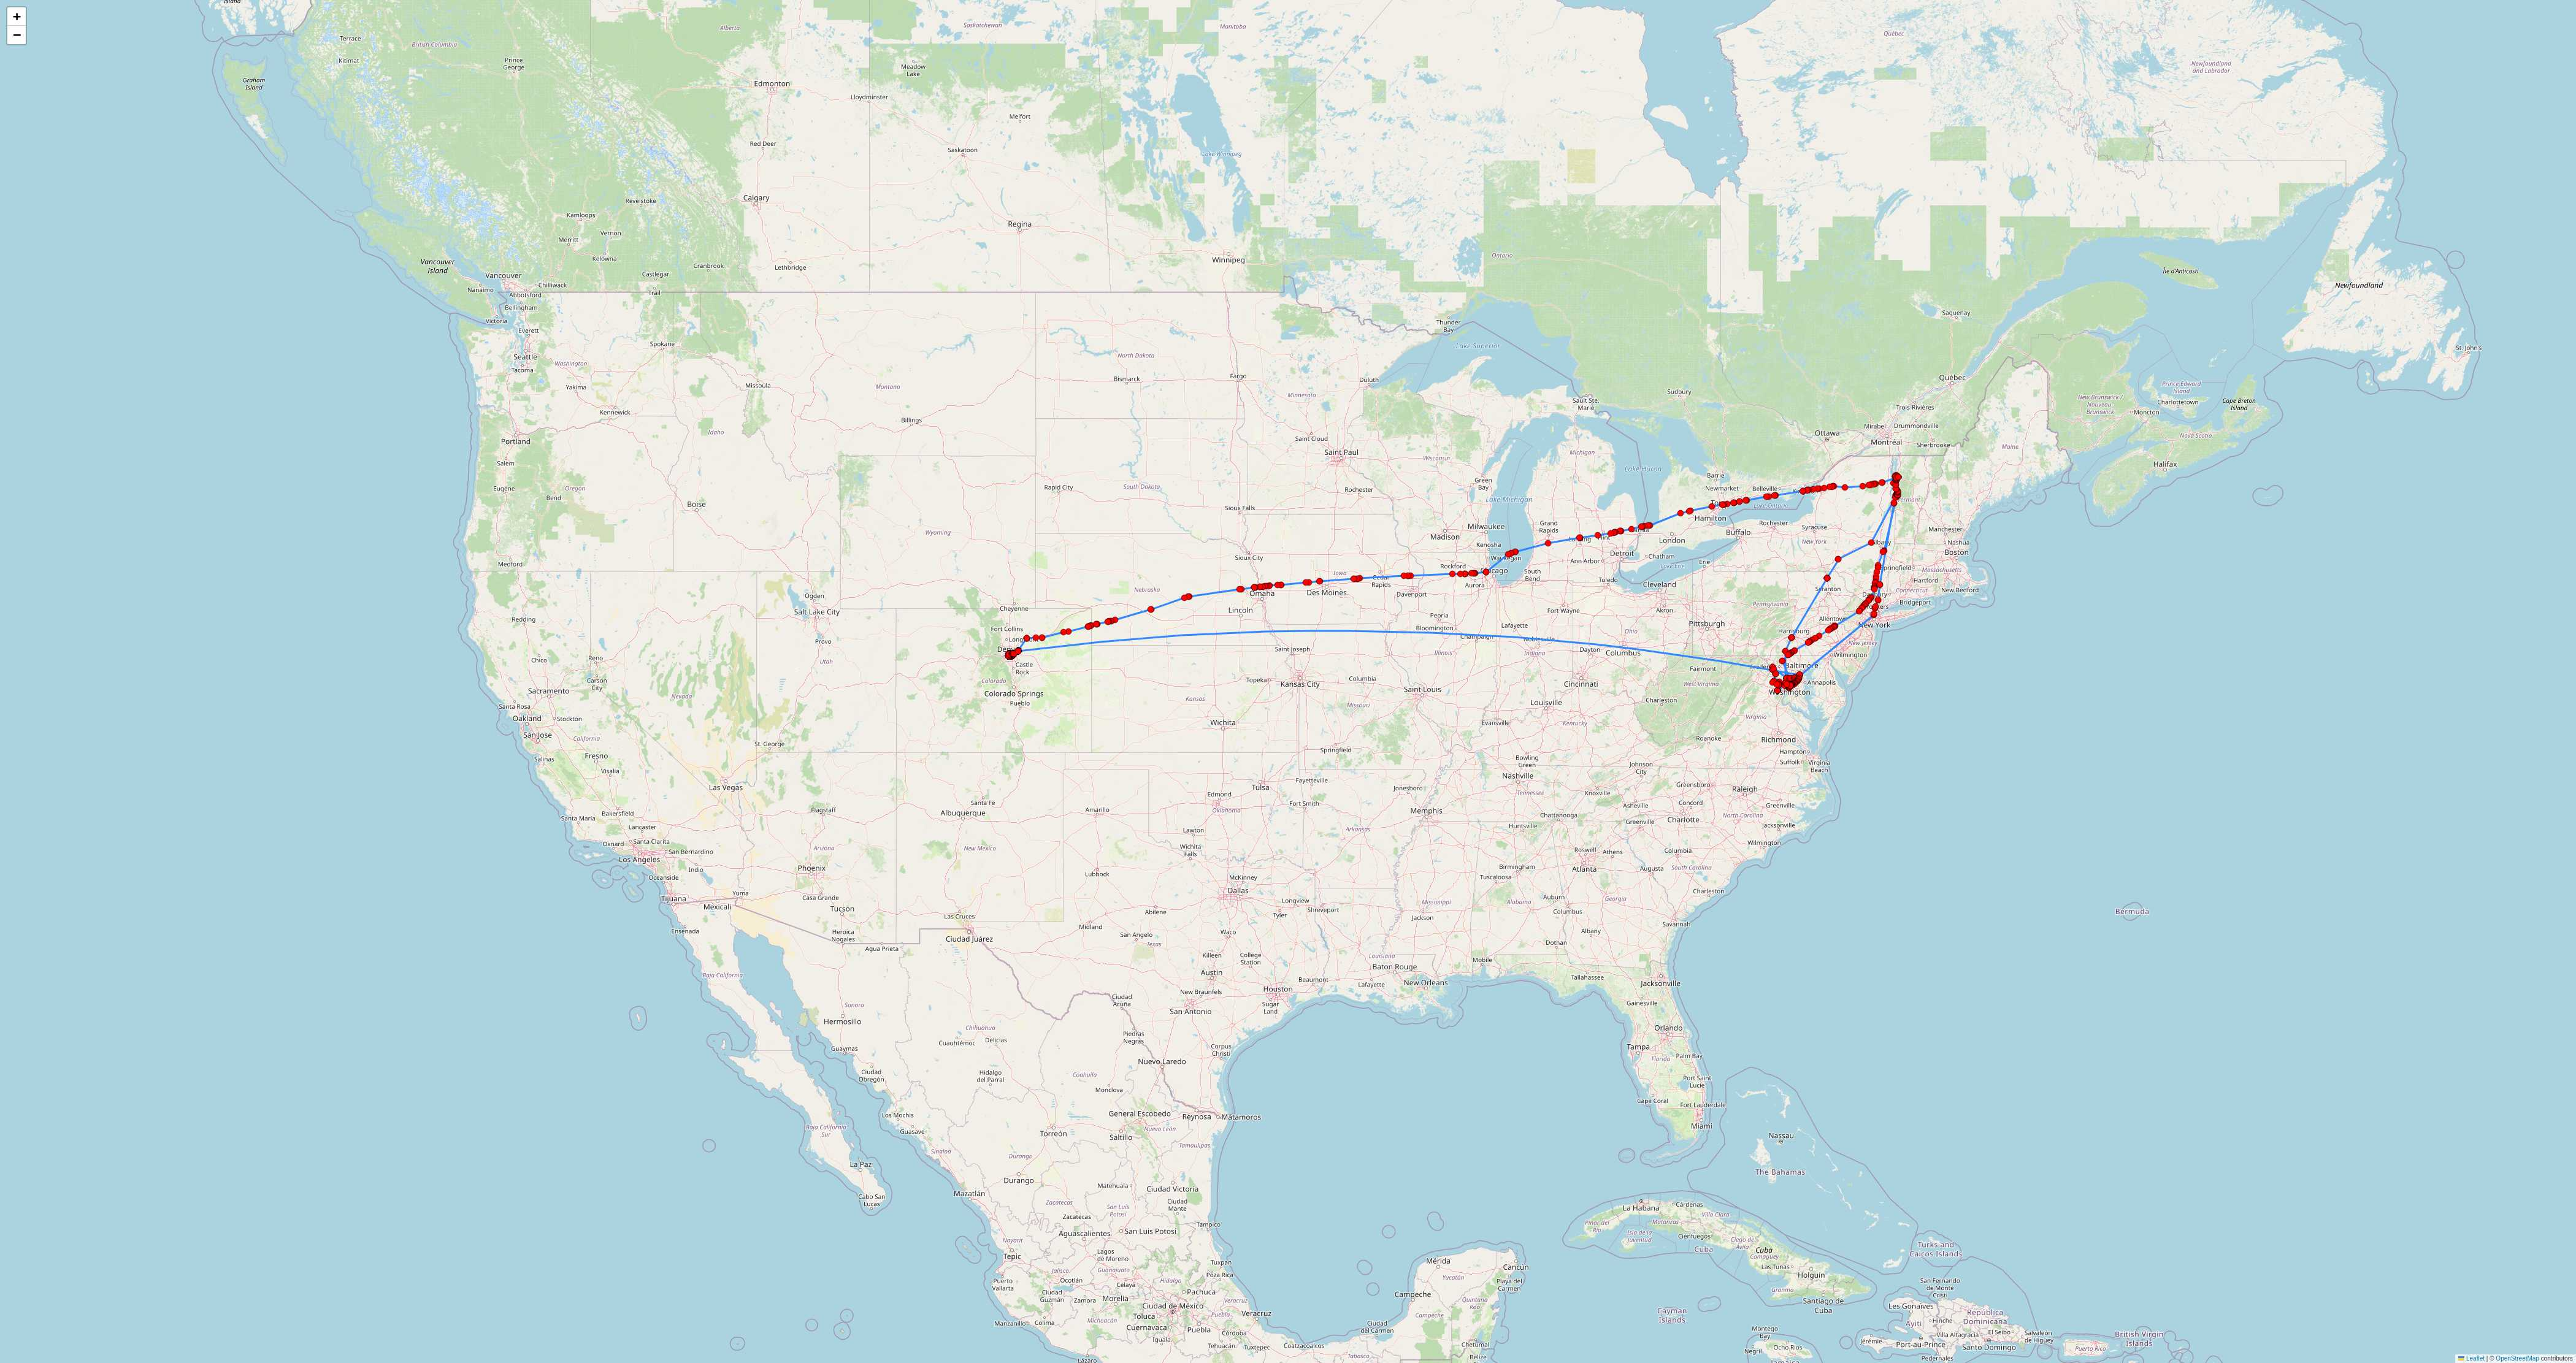

In [31]:
IPython.display.display(IPython.display.Image(
    filename='smaller_screenshots/'+'2012_combined_locations.jpg'))

Meanwhile, in 2015, many of my trips originated from Houston:

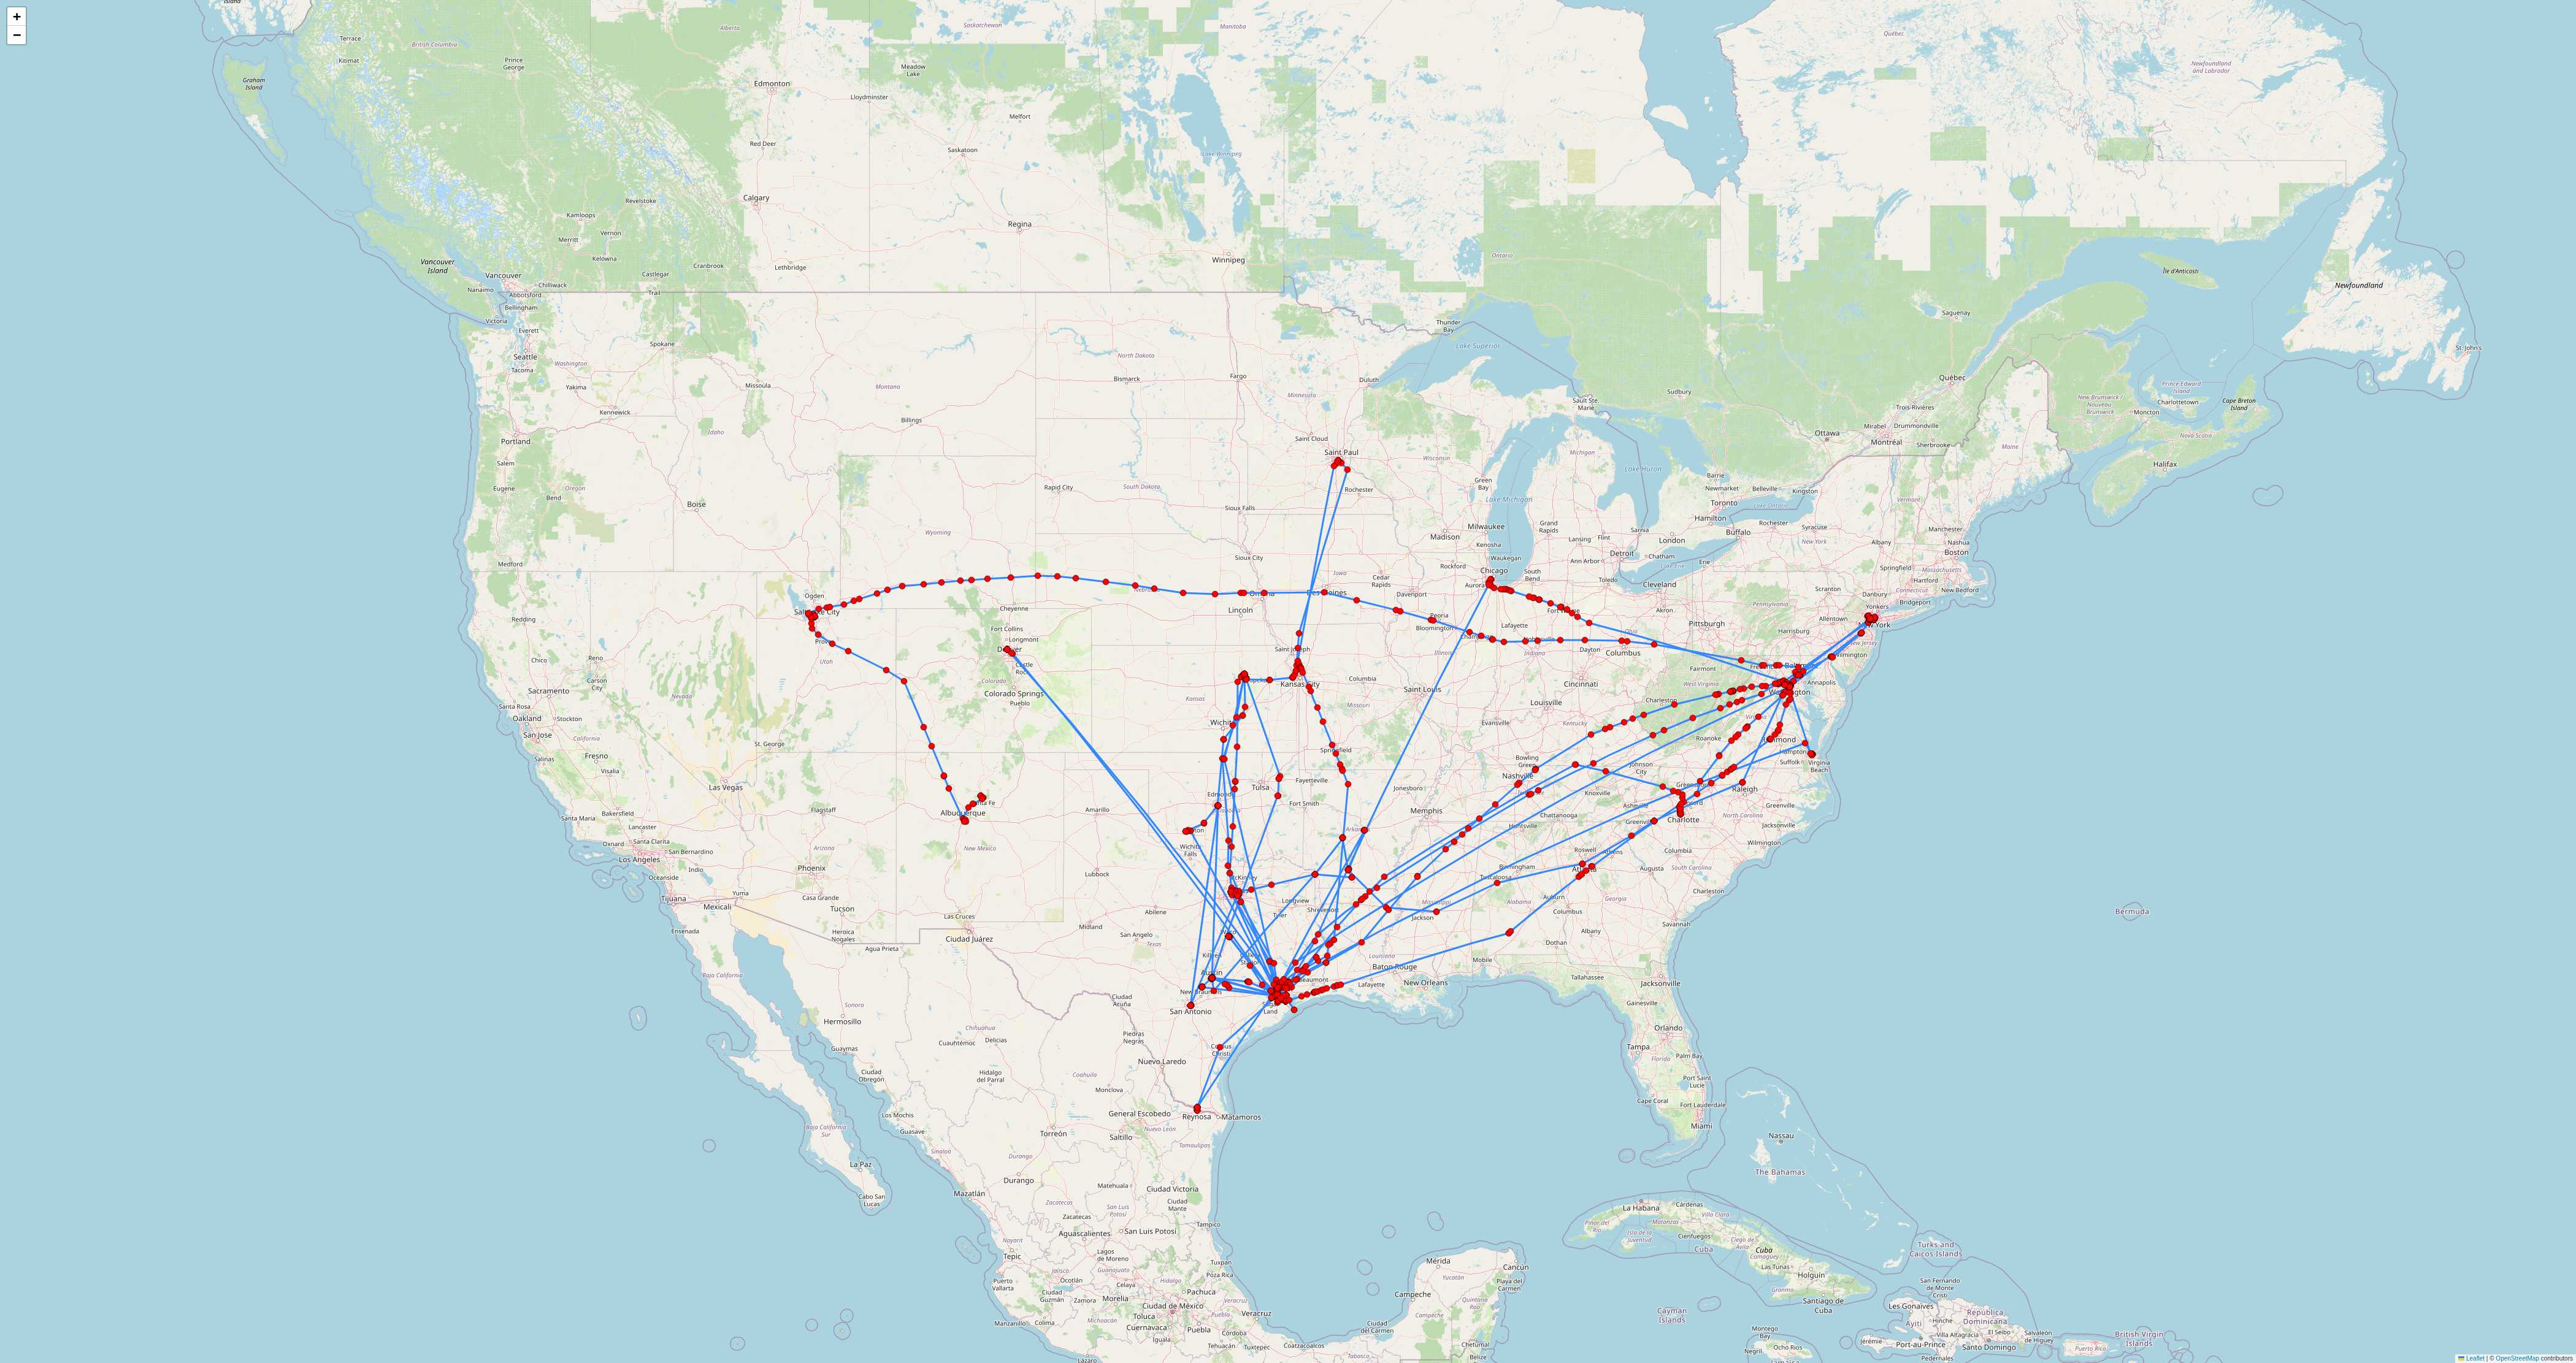

In [32]:
IPython.display.display(IPython.display.Image(
    filename='smaller_screenshots/'+'2015_combined_locations.jpg'))

And in 2022, most of my travels were focused on the East Coast:

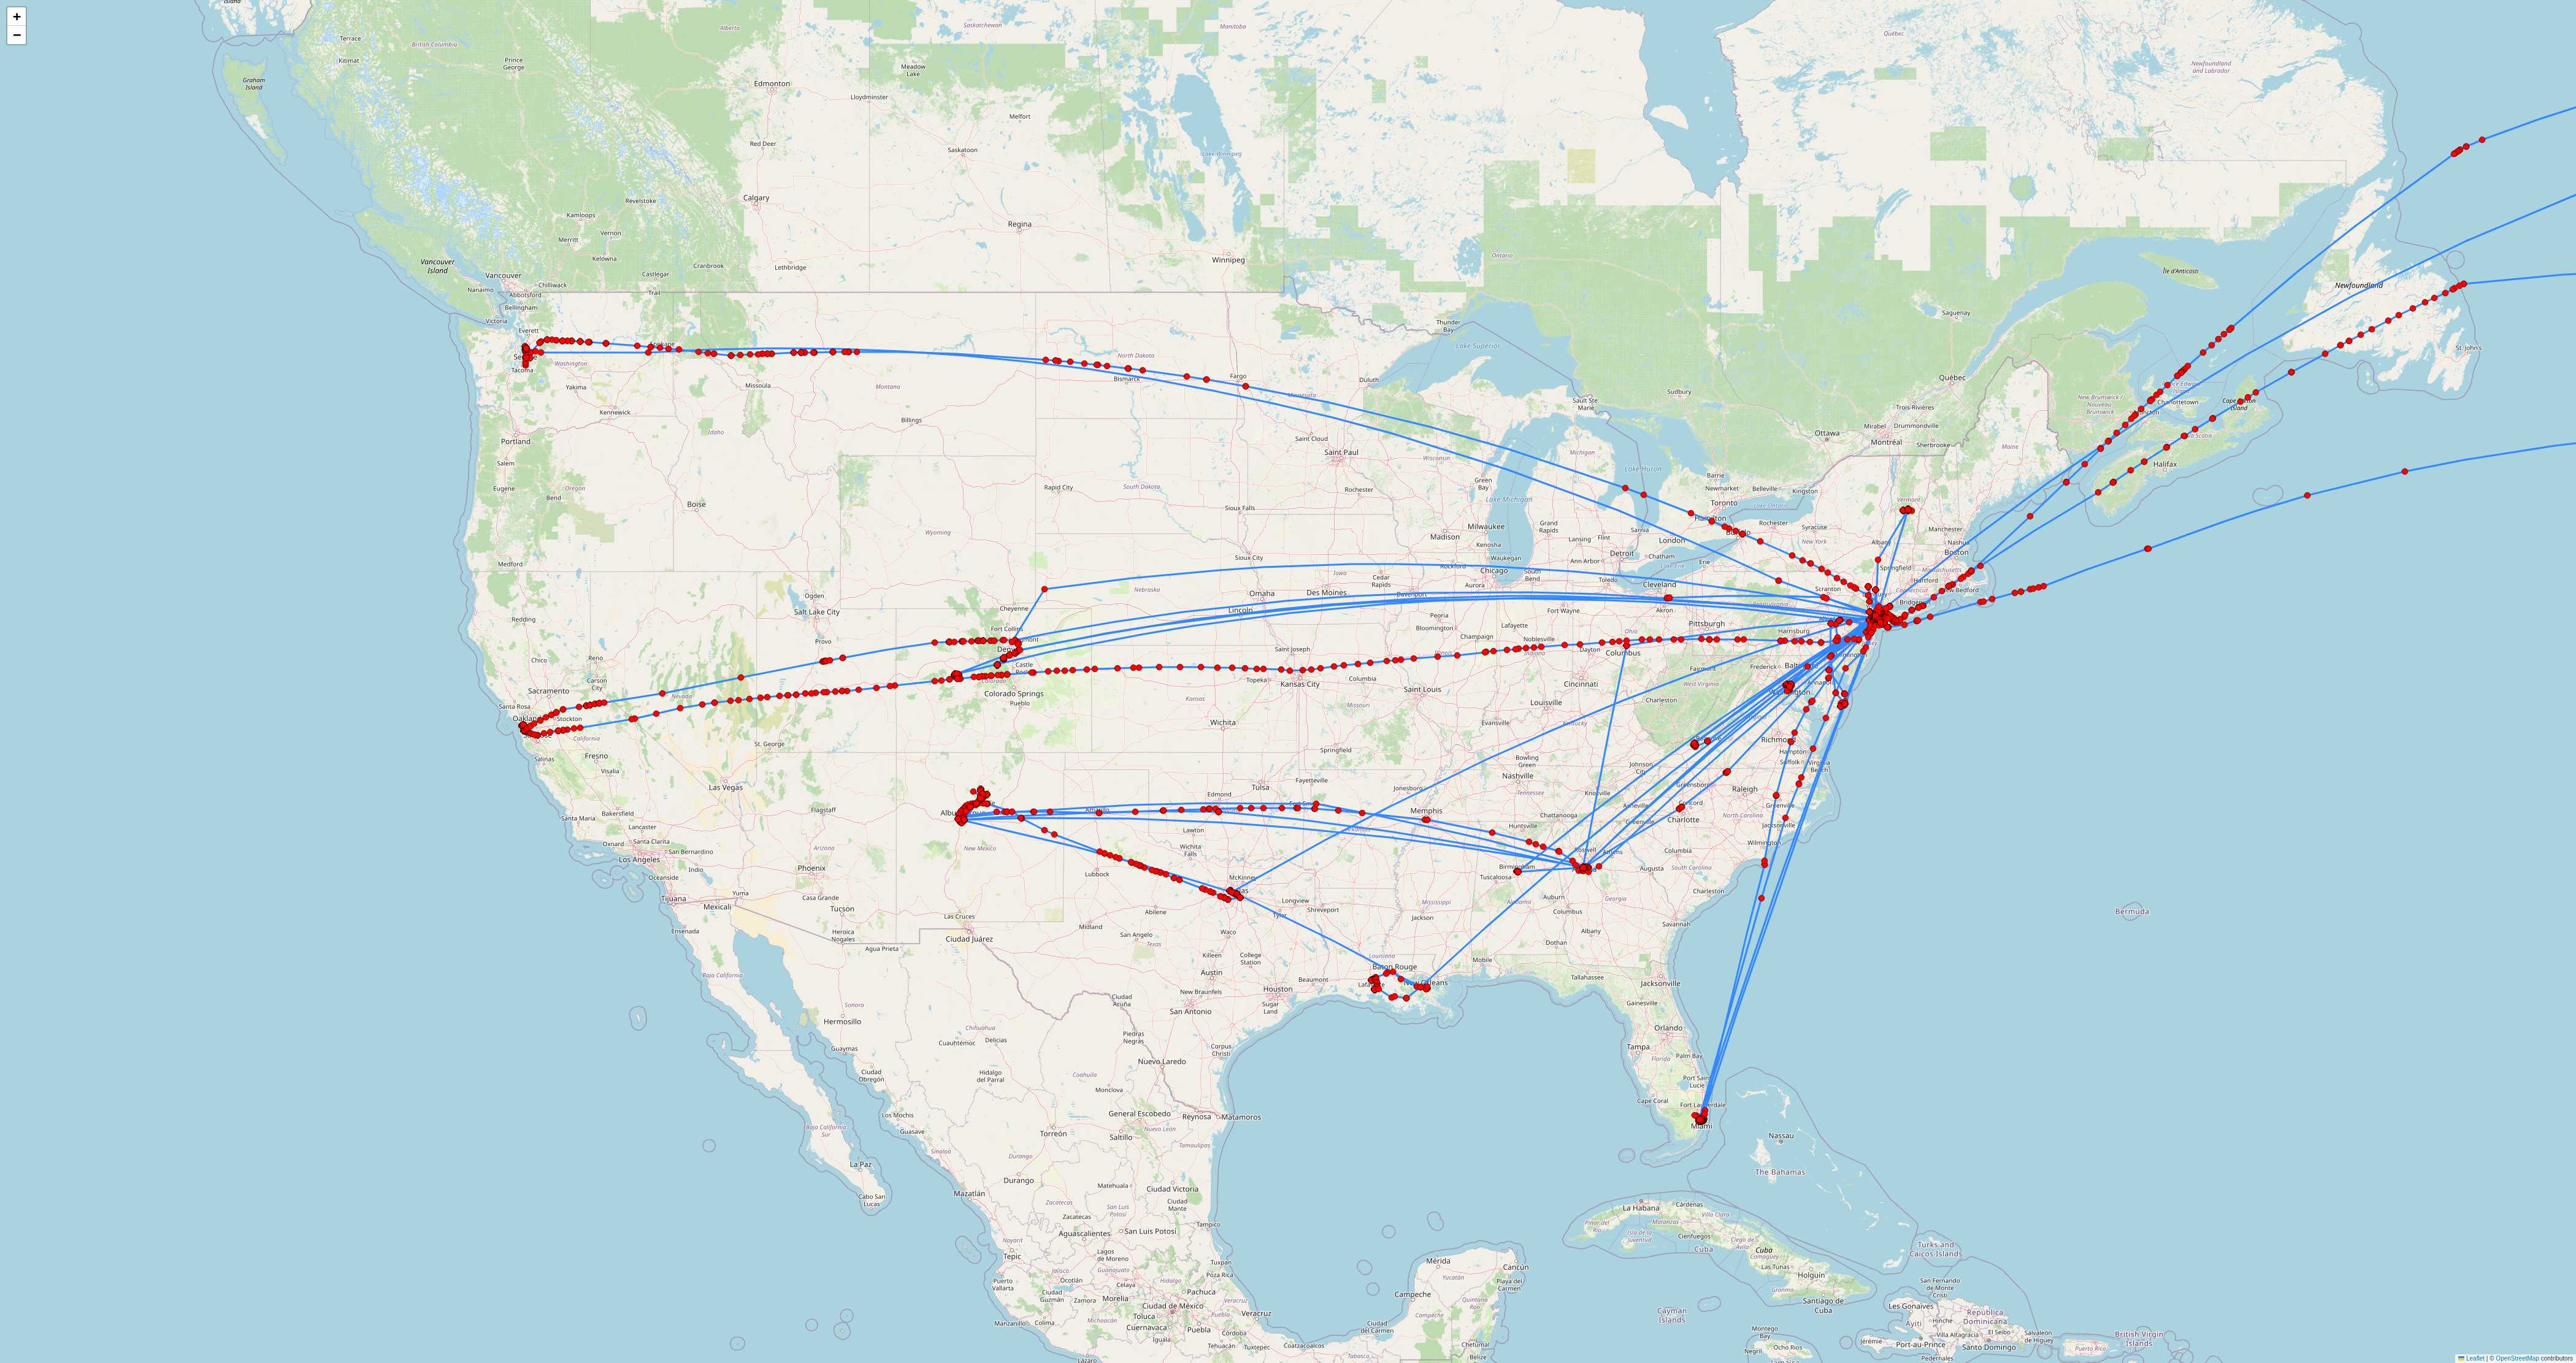

In [33]:
IPython.display.display(IPython.display.Image(
    filename='smaller_screenshots/'+'2022_combined_locations.jpg'))

The code block below would display all maps within the smaller_screenshots folder via a for loop. However, I commented it out because running it prevented the notebook from displaying on GitHub. 

In [34]:
# for map in smaller_screenshot_list:
#     print(f'\n\n{map}:')
#     IPython.display.display(IPython.display.Image(
#         filename='smaller_screenshots/'+map))

# # This method of displaying images within a loop comes from Stack Overflow
# # user DrMcCleod at https://stackoverflow.com/a/35061341/13097194 .


## How far have I traveled each year?

Using this geotag data, I can also retrieve a rough estimate of how far I've traveled each year. I'll do so by using the calculate_distance_by_year() function to determine the distance in between each point (for years 2013 to 2022), then sum them all up. (This requires that the points are sorted in chronological order, but I took care of that when creating df_locations.)

calculate_distance_by_year uses the haversine library to calculate the haversine/great-circle distance between points, which is more accurate than the Euclidean distance (given that the Earth is curved). This library also handles trips across the international date line well:

In [35]:
from haversine import haversine, Unit
prev_pt = [50, -170]
cur_pt = [50, 170]
haversine(prev_pt, cur_pt,
            unit = Unit.MILES)

885.5905764533472

Here's a table showing my estimate of the total distance (in miles) that I've traveled each year:

In [37]:
df_distances_by_year = calculate_distance_by_year(
    df_locations)

df_distances_by_year

year  total_distance  geotags
0   2012     5021.595947     1448
1   2013    36825.194201     4199
2   2014    15744.195475     1728
3   2015    26568.502606     1286
4   2016    20557.269702     2871
5   2017     3177.863618      239
6   2018    16356.698039      327
7   2019     9592.872301      289
8   2020    14425.535368     2164
9   2021    22156.316158     5958
10  2022    63886.607827    10399
11  2023    38423.909160     6494
12  2024    10915.759020     8764
13  2025    16936.477863     7074
14  2026        0.032052        6

According to this estimate, I traveled around 229,000 miles from January 2013 to December 2022:

In [38]:
sum(df_distances_by_year.query("year >= 2013 & year <= 2022")['total_distance'])

229291.0552950976

How accurate are these estimates? They're certainly not perfect; after all, I don't take pictures and videos all the time when I travel (although I do take lots of them), and there are probably at least some points within my table that aren't in the correct order.

However, for comparison, I flew 233,000 miles during this same timeframe (according to another spreadsheet), so this value is plausible. (The flights spreadsheet doesn't capture road and train trips, but df_distances_by_year does.)

I can also plot these yearly totals as a bar chart:

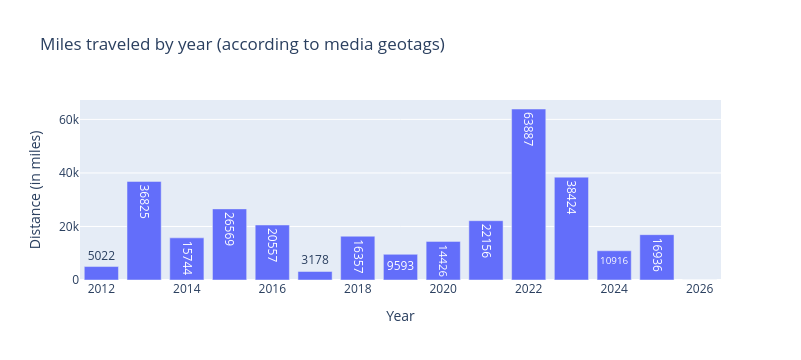

In [45]:
px.bar(df_distances_by_year, x = 'year', 
y = 'total_distance', text_auto = '.0f',
title = 'Miles traveled by year (according to media \
geotags)').update_layout(yaxis_title = 'Distance (in miles)',
xaxis_title = 'Year')

Copying two HTML-based maps to a docs folder for display via GitHub pages:

In [52]:
for file in ['2022_04_Miami_trip_locations.html',
             '2022_03_Israel_trip_locations.html']:
    shutil.copy(f'maps/{file}', f'docs/{file}')

That's it for this tutorial program! I had a lot of fun creating it, and I hope that you'll enjoy using it to plot out your own journeys! 

In [42]:
program_end_time = time.time()
run_time = program_end_time - program_start_time
run_minutes = run_time // 60
run_seconds = run_time % 60
print("Completed run at",time.ctime(program_end_time),"(local time)")
print("Total run time:",'{:.2f}'.format(run_time),
"second(s) ("+str(run_minutes),"minute(s) and",'{:.2f}'.format(run_seconds),
"second(s))") 
# Only meaningful when the program is run nonstop from start to finish

Completed run at Tue Jan  6 21:42:06 2026 (local time)
Total run time: 297.93 second(s) (4.0 minute(s) and 57.93 second(s))
